# Load Metadata from CSV

In [1]:
import numpy as np
import pandas as pd


In [2]:
def load_df(path):
    train_df = pd.read_csv(path)
    X = train_df['id']
    y = train_df['landmark_id']
    
    return train_df, X, y

path = '../data/metadata/train_200.csv'

train_df, X, y = load_df(path)

In [3]:
NUM_CLASSES = train_df['landmark_id'].unique().shape[0]
NUM_CLASSES

1066

# Seperating into Training, Validating, Testing

In [4]:
# map selected landmark ids to classes
# {landmark_id: class} 
# {995:0, 12345:1, ....}
landmarks = train_df['landmark_id'].unique()
landmark_to_idx = {}
i = 0
for k in landmarks:
    landmark_to_idx[k] = i
    i += 1

In [5]:
from sklearn.model_selection import StratifiedShuffleSplit

# split train & (validation + test)
split_rule = StratifiedShuffleSplit(n_splits=1, test_size=0.22, random_state=9)

for train_id, test_id in split_rule.split(X, y):
    X_train, X_val_test = X.iloc[train_id], X.iloc[test_id]
    y_train, y_val_test = y.iloc[train_id], y.iloc[test_id]

# split validation & test
split_rule2 = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=9)
for train_id, test_id in split_rule2.split(X_val_test, y_val_test):
    X_valid, X_test = X_val_test.iloc[train_id], X_val_test.iloc[test_id]
    y_valid, y_test = y_val_test.iloc[train_id], y_val_test.iloc[test_id]

In [6]:
print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('X_valid shape: ', X_valid.shape)
print('y_valid shape: ', y_valid.shape)
print('X_test shape: ', X_test.shape)
print('y_test shape: ', y_test.shape)

X_train shape:  (630286,)
y_train shape:  (630286,)
X_valid shape:  (88887,)
y_valid shape:  (88887,)
X_test shape:  (88887,)
y_test shape:  (88887,)


In [7]:
valid_id_list = list(zip(list(X_valid), list(y_valid)))
train_id_list = list(zip(list(X_train), list(y_train)))

# Data Generator
- Loading image data based on the seperating rules on the fly

In [8]:
import os
import random
import shutil
import tarfile
import cv2
import numpy as np
#from keras.utils import Sequence
from tensorflow.python.keras.utils.data_utils import Sequence
#import keras



class DataGen(Sequence):
    def __init__(self, id_list, landmark_to_idx, batch_size=128, verbose=1):
        self.batch_size=batch_size
        self.id_list = id_list
        self.landmark_to_idx = landmark_to_idx


    def __getitem__(self, index):
        batch_id_list = random.sample(self.id_list, self.batch_size)
        landmark_to_idx = self.landmark_to_idx
        #num_classes = self.num_classes
        
        output = []
        label_idx = []
        for ix, ids in enumerate(batch_id_list):
            img_id = ids[0]
            ldmk_id = ids[1]
            path = '../train/'+str(ldmk_id)+'/'+img_id+'.jpg'
            try: 
                im = cv2.imread(path)
                im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
                if im.size != 0:
                    output.append(im)
                    ldmk_idx = landmark_to_idx[ldmk_id]
                    label_idx.append(ldmk_idx)
            except:
                continue
        
        x = np.array(output)
        y = np.zeros((len(output), NUM_CLASSES))
        for i in range(len(label_idx)):
            y[i,label_idx[i]] = 1.
        
        return x,y
            
    def on_epoch_end(self):
        return

    def __len__(self):
        #return len(valid_urls_list) // self.batch_size
        return 10

/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passi

In [9]:
validation_generator = DataGen(valid_id_list, landmark_to_idx)
training_generator = DataGen(train_id_list, landmark_to_idx)

# Modeling

In [10]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Input, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
print(tf.__version__)

2.0.0-alpha0


# VGG 16

In [11]:
from tensorflow.keras.applications.vgg16 import VGG16
vgg16 = VGG16(include_top=False, weights='imagenet', input_shape=(128, 128, 3))

In [12]:
for layer in vgg16.layers[:2]:
    layer.trainable = False

x = vgg16.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(NUM_CLASSES, activation="softmax")(x)

model = Model(vgg16.input, predictions)

opt = Adam(0.0001)    
model.compile(optimizer=opt, 
              loss='categorical_crossentropy', 
              metrics=['categorical_accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

# Epoch 0 - 100

In [13]:
checkpointer_vgg = ModelCheckpoint(filepath='../saved_model/weights_vgg16.h5', 
                               verbose=1, save_best_only=True)

In [14]:
history_vgg = model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    use_multiprocessing=True,
                    callbacks=[checkpointer_vgg],
                    epochs=100,
                    workers=8,
                    verbose=1)

Epoch 1/100
 9/10 [==========================>...] - ETA: 1s - loss: 8.5828 - categorical_accuracy: 0.0052
Epoch 00001: val_loss improved from inf to 6.93316, saving model to ../saved_model/weights_vgg16.h5
10/10 [==============================] - 14s 1s/step - loss: 8.4189 - categorical_accuracy: 0.0047 - val_loss: 6.9332 - val_categorical_accuracy: 0.0039
Epoch 2/100
 9/10 [==========================>...] - ETA: 0s - loss: 6.9333 - categorical_accuracy: 0.0000e+00
Epoch 00002: val_loss improved from 6.93316 to 6.87360, saving model to ../saved_model/weights_vgg16.h5
10/10 [==============================] - 8s 818ms/step - loss: 6.9305 - categorical_accuracy: 0.0047 - val_loss: 6.8736 - val_categorical_accuracy: 0.0594
Epoch 3/100
 9/10 [==========================>...] - ETA: 0s - loss: 6.8661 - categorical_accuracy: 0.0434
Epoch 00003: val_loss improved from 6.87360 to 6.87066, saving model to ../saved_model/weights_vgg16.h5
10/10 [==============================] - 9s 895ms/step - lo

# Epoch 100 - 120

In [15]:
checkpointer_vgg2 = ModelCheckpoint(filepath='../saved_model/weights_vgg16_2.h5', 
                               verbose=1, save_best_only=True)

history_vgg2 = model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    use_multiprocessing=True,
                    callbacks=[checkpointer_vgg2],
                    epochs=20,
                    workers=8,
                    verbose=1)

Epoch 1/20
 9/10 [==========================>...] - ETA: 0s - loss: 2.5760 - categorical_accuracy: 0.4948

Epoch 00001: val_loss improved from inf to 2.55292, saving model to ../saved_model/weights_vgg16_2.h5
10/10 [==============================] - 8s 845ms/step - loss: 2.5831 - categorical_accuracy: 0.4938 - val_loss: 2.5529 - val_categorical_accuracy: 0.4875
Epoch 2/20
 9/10 [==========================>...] - ETA: 0s - loss: 2.4899 - categorical_accuracy: 0.5104
Epoch 00002: val_loss improved from 2.55292 to 2.43949, saving model to ../saved_model/weights_vgg16_2.h5
10/10 [==============================] - 6s 587ms/step - loss: 2.4847 - categorical_accuracy: 0.5094 - val_loss: 2.4395 - val_categorical_accuracy: 0.5063
Epoch 3/20
 9/10 [==========================>...] - ETA: 0s - loss: 2.5007 - categorical_accuracy: 0.5260
Epoch 00003: val_loss did not improve from 2.43949
10/10 [==============================] - 5s 544ms/step - loss: 2.4728 - categorical_accuracy: 0.5250 - val_loss:

# Epoch 120 - 160

In [16]:
checkpointer_vgg3 = ModelCheckpoint(filepath='../saved_model/weights_vgg16_3.h5', 
                               verbose=1, save_best_only=True)

history_vgg3 = model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    use_multiprocessing=True,
                    callbacks=[checkpointer_vgg2],
                    epochs=40,
                    workers=8,
                    verbose=1)

Epoch 1/40
 9/10 [==========================>...] - ETA: 0s - loss: 1.9865 - categorical_accuracy: 0.6050
Epoch 00001: val_loss did not improve from 1.95183
10/10 [==============================] - 8s 799ms/step - loss: 2.0159 - categorical_accuracy: 0.6000 - val_loss: 2.1419 - val_categorical_accuracy: 0.5602
Epoch 2/40
 9/10 [==========================>...] - ETA: 0s - loss: 2.2147 - categorical_accuracy: 0.5712
Epoch 00002: val_loss did not improve from 1.95183
10/10 [==============================] - 6s 598ms/step - loss: 2.2193 - categorical_accuracy: 0.5672 - val_loss: 2.0281 - val_categorical_accuracy: 0.5969
Epoch 3/40
 9/10 [==========================>...] - ETA: 0s - loss: 2.1669 - categorical_accuracy: 0.5460
Epoch 00003: val_loss did not improve from 1.95183
10/10 [==============================] - 5s 539ms/step - loss: 2.1534 - categorical_accuracy: 0.5516 - val_loss: 2.1063 - val_categorical_accuracy: 0.5813
Epoch 4/40
 9/10 [==========================>...] - ETA: 0s - lo

# ResNet 50

In [42]:
from tensorflow.keras.applications.resnet50 import ResNet50

resnet = ResNet50(include_top=False, weights='imagenet', input_shape=(128, 128, 3))

In [43]:
checkpointer_resnet = ModelCheckpoint(filepath='../saved_model/resnet_no_aug.h5', 
                               verbose=1, save_best_only=True)

In [44]:
for layer in resnet.layers[-5:]:
    layer.trainable = False
    
out = Flatten()(resnet.output)
out = Dense(NUM_CLASSES, activation='softmax')(out)
model2 = Model(resnet.input, out)
model2.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalizationV1) (None, 64, 64, 64)   256         conv1[0][0]                      
____________________________________________________________________________________________

In [45]:
opt = Adam(0.0001)
model2.compile(loss="categorical_crossentropy", optimizer=opt, metrics=['categorical_accuracy'])
history_resnet = model2.fit_generator(generator=training_generator,
                     validation_data=validation_generator,
                     epochs=80,
                     callbacks=[checkpointer_resnet],
                     use_multiprocessing=True,
                     workers=8,
                     verbose=1)

Epoch 1/80
 9/10 [==========================>...] - ETA: 5s - loss: 8.1816 - categorical_accuracy: 0.0512 
Epoch 00001: val_loss improved from inf to 8.58699, saving model to ../saved_model/resnet_no_aug.h5
10/10 [==============================] - 59s 6s/step - loss: 8.1358 - categorical_accuracy: 0.0578 - val_loss: 8.5870 - val_categorical_accuracy: 0.0891
Epoch 2/80
 9/10 [==========================>...] - ETA: 0s - loss: 7.1096 - categorical_accuracy: 0.1085
Epoch 00002: val_loss improved from 8.58699 to 7.74949, saving model to ../saved_model/resnet_no_aug.h5
10/10 [==============================] - 14s 1s/step - loss: 6.9543 - categorical_accuracy: 0.1133 - val_loss: 7.7495 - val_categorical_accuracy: 0.1227
Epoch 3/80
 9/10 [==========================>...] - ETA: 0s - loss: 5.9399 - categorical_accuracy: 0.1267
Epoch 00003: val_loss did not improve from 7.74949
10/10 [==============================] - 7s 675ms/step - loss: 5.9119 - categorical_accuracy: 0.1273 - val_loss: 9.5063 

# Training Result Visualization

In [42]:
import matplotlib.pyplot as plt
def plot_history(history, plot_title1, plot_title2):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(15, 5)
  
    ax1.plot(history.history['loss'])
    ax1.plot(history.history['val_loss'])
    ax1.set_title(plot_title1)
    ax1.set(xlabel='epoch', ylabel='loss')
    ax1.legend(['train', 'test'], loc='upper left')
    
    ax2.plot(history.history['categorical_accuracy'])
    ax2.plot(history.history['val_categorical_accuracy'])
    ax2.set_title(plot_title2)
    ax2.set(xlabel='epoch', ylabel='categorical_accuracy')
    ax2.legend(['train', 'test'], loc='upper left')
    
    return fig

# VGG 16 Epoch 0-100, 120 - 140, 140 - 160

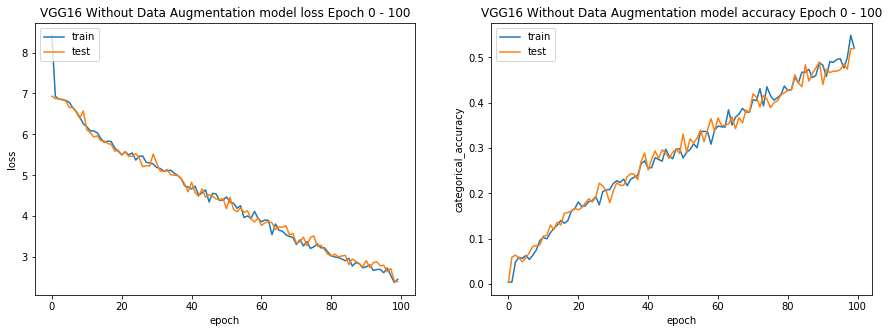

In [43]:
loss_vgg_100 = 'VGG16 Without Data Augmentation model loss Epoch 0 - 100'
acc_vgg_100 = 'VGG16 Without Data Augmentation model accuracy Epoch 0 - 100'
fig1 = plot_history(history_vgg, loss_vgg_100, acc_vgg_100)

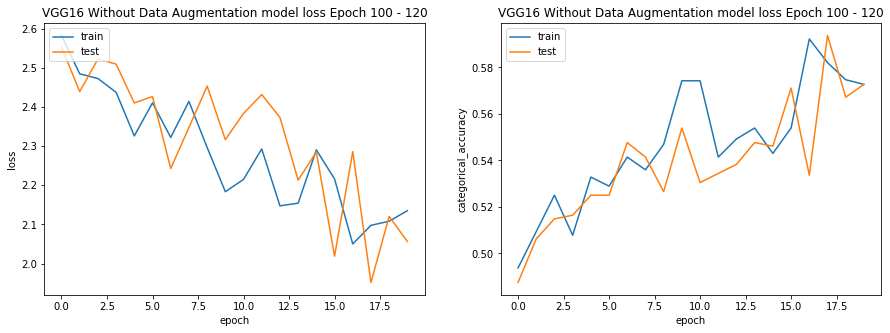

In [45]:
loss_vgg_120 = 'VGG16 Without Data Augmentation model loss Epoch 100 - 120'
acc_vgg_120 = 'VGG16 Without Data Augmentation model accuracy Epoch 100 - 120'
fig2 = plot_history(history_vgg2, loss_vgg_120, loss_vgg_120)

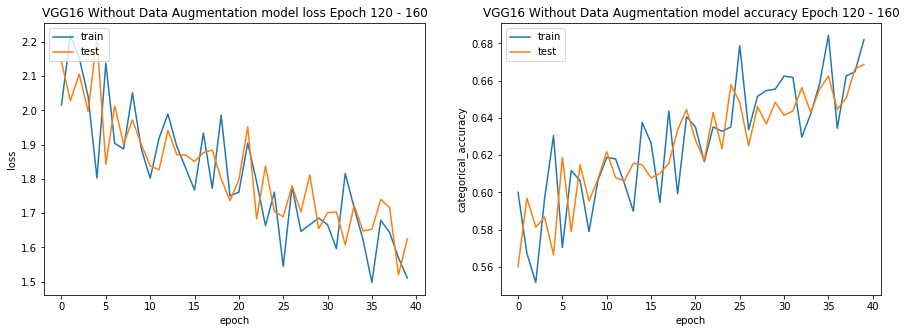

In [46]:
loss_vgg_160 = 'VGG16 Without Data Augmentation model loss Epoch 120 - 160'
acc_vgg_160 = 'VGG16 Without Data Augmentation model accuracy Epoch 120 - 160'
fig3 = plot_history(history_vgg3, loss_vgg_160, acc_vgg_160)

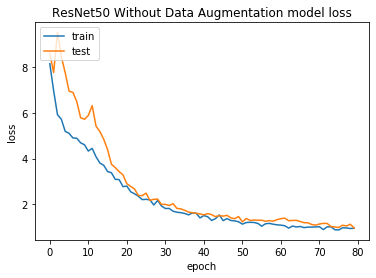

In [48]:


# summarize history for loss
plt.plot(history_resnet.history['loss'])
plt.plot(history_resnet.history['val_loss'])
plt.title('ResNet50 Without Data Augmentation model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

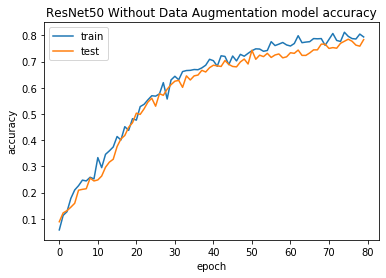

In [51]:
# summarize history for accuracy
plt.plot(history_resnet.history['categorical_accuracy'])
plt.plot(history_resnet.history['val_categorical_accuracy'])
plt.title('ResNet50 Without Data Augmentation model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()